# Strategic Thinking for Data Analysis - CA3

### Data Source

The source of the datasets is Kaggle, which provides public datasets for analysis. Two datasets generated from photovoltaic energy generation and temperature sensor data from two solar plants in India will be used. These datasets contain 34 days of generation data from the year 2020.

In order to facilitate and simplify the analysis, data from only one of the Photovoltaic Plants will be used.

**Dataset names:** Plant_1_Generation_Data and Plant_1_Weather_Data.


### Variable Identification
#### Generation data
- DATE_TIME - Date and time for each observation. Observations recorded at 15 minute intervals.
- PLANT_ID - Plant ID number.
- INVERTER - Inverter id.
- DC_POWER - Amount of DC power generated by the Inverter in this 15 minute interval (kW).
- AC_POWER - Amount of AC power generated by the Inverter in this 15 minute interval (kW).
- DAILY_YIELD - Daily yield is a cumulative sum of power generated on that day, till that point in time.
- TOTAL_YIELD - This is the total yield for the inverter till that point in time.

#### Tempearture and Solar Irradiation data
- DATE_TIME - Date and time for each observation. Observations recorded at 15 minute intervals.
- Plant ID - this will be common for the entire file.
- SENSOR - Stands for the sensor panel id.
- AMBIENT_TEMPERATURE - This is the ambient temperature at the plant.
- MODULE_TEMPERATURE - There is a module (solar panel) attached to the sensor panel. This is the temperature reading for that module.
- IRRADIATION - Amount of irradiation for the 15 minute interval.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor  

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings("ignore")


## Data Loading

In [2]:
# Loading the Generation Data set 1
df_gen = pd.read_csv('Data\Plant_1_Generation_Data.csv')
df_gen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68778 entries, 0 to 68777
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE_TIME    68778 non-null  object 
 1   PLANT_ID     68778 non-null  int64  
 2   SOURCE_KEY   68778 non-null  object 
 3   DC_POWER     68778 non-null  float64
 4   AC_POWER     68778 non-null  float64
 5   DAILY_YIELD  68778 non-null  float64
 6   TOTAL_YIELD  68778 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 3.7+ MB


In [3]:
# Loading the Weather Data set 1
df_wth = pd.read_csv('Data\Plant_1_Weather_Sensor_Data.csv')
df_wth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3182 entries, 0 to 3181
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DATE_TIME            3182 non-null   object 
 1   PLANT_ID             3182 non-null   int64  
 2   SOURCE_KEY           3182 non-null   object 
 3   AMBIENT_TEMPERATURE  3182 non-null   float64
 4   MODULE_TEMPERATURE   3182 non-null   float64
 5   IRRADIATION          3182 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 149.3+ KB


### Converting the 'DATE_TIME' column to datetime type

In [4]:
df_gen['DATE_TIME']= pd.to_datetime(df_gen['DATE_TIME'],format='%d-%m-%Y %H:%M')
df_gen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68778 entries, 0 to 68777
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DATE_TIME    68778 non-null  datetime64[ns]
 1   PLANT_ID     68778 non-null  int64         
 2   SOURCE_KEY   68778 non-null  object        
 3   DC_POWER     68778 non-null  float64       
 4   AC_POWER     68778 non-null  float64       
 5   DAILY_YIELD  68778 non-null  float64       
 6   TOTAL_YIELD  68778 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 3.7+ MB


In [5]:
df_wth['DATE_TIME']= pd.to_datetime(df_wth['DATE_TIME'],format='%Y-%m-%d %H:%M:%S')
df_wth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3182 entries, 0 to 3181
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE_TIME            3182 non-null   datetime64[ns]
 1   PLANT_ID             3182 non-null   int64         
 2   SOURCE_KEY           3182 non-null   object        
 3   AMBIENT_TEMPERATURE  3182 non-null   float64       
 4   MODULE_TEMPERATURE   3182 non-null   float64       
 5   IRRADIATION          3182 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 149.3+ KB


### Aggregation into Time Intervals

Preparation and organization for generation data analysis, aggregating them into larger time intervals.
Conversion of the time column to datetime formats and separating the date and time into distinct columns to facilitate analysis.

#### Generation Dataframe

In [6]:
plant1_data=df_gen

# Group the data by the column 'DATE_TIME' and aggregate
# outhers columns by summing their values
plant1_data = plant1_data.groupby('DATE_TIME')[['DC_POWER',
                                                'AC_POWER', 
                                                'DAILY_YIELD',
                                                'TOTAL_YIELD']].agg('sum')

# Reset the index to make 'DATE_TIME' a regular column again
plant1_data = plant1_data.reset_index()

# Convert the 'DATE_TIME' column to datetime format,
# coercing errors to NaT (Not a Time) for any invalid values
plant1_data['DATE_TIME'] = pd.to_datetime(plant1_data['DATE_TIME'], errors='coerce')

# Storing DATE_TIME' in a new column 'time'
plant1_data['time'] = plant1_data['DATE_TIME'].dt.time

# Convert the 'DATE_TIME' column to datetime format and store in a new column 'date'
plant1_data['date'] = pd.to_datetime(plant1_data['DATE_TIME'].dt.date)

#### Temperature Dataframe

In [7]:
plant1_sensor = df_wth

# Convert the 'DATE_TIME' column to datetime format,
# coercing errors to NaT (Not a Time) for any invalid values
plant1_sensor['DATE_TIME'] = pd.to_datetime(plant1_sensor['DATE_TIME'], errors='coerce')

# Storing DATE_TIME' in a new column 'time
plant1_sensor['time'] = pd.to_datetime(plant1_sensor['DATE_TIME']).dt.time

# Convert the 'DATE_TIME' column to datetime format and store in a new column 'date'
plant1_sensor['date'] = pd.to_datetime(pd.to_datetime(plant1_sensor['DATE_TIME']).dt.date)

### Merging Dataframes

Merging the plant1_sensor and plant1_data DataFrames using the 'DATE_TIME' column as the key. This results in a new DataFrame called power_sensor that contains all columns from both DataFrames, but combined based on the timestamp. Removing redundant columns from the power_sensor DataFrame, which were created as a result of merging the DataFrames. These columns are removed because they are duplicates.

In [8]:
# Merge the DataFrames plant1_sensor and plant1_data based on the 'DATE_TIME' column
power_sensor = plant1_sensor.merge(plant1_data, left_on='DATE_TIME', right_on='DATE_TIME')

# Delete unnecessary columns from the merged DataFrame
del power_sensor['date_x']
del power_sensor['date_y']
del power_sensor['time_x']
del power_sensor['time_y']

### Verify Data Type

In [9]:
power_sensor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3157 entries, 0 to 3156
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE_TIME            3157 non-null   datetime64[ns]
 1   PLANT_ID             3157 non-null   int64         
 2   SOURCE_KEY           3157 non-null   object        
 3   AMBIENT_TEMPERATURE  3157 non-null   float64       
 4   MODULE_TEMPERATURE   3157 non-null   float64       
 5   IRRADIATION          3157 non-null   float64       
 6   DC_POWER             3157 non-null   float64       
 7   AC_POWER             3157 non-null   float64       
 8   DAILY_YIELD          3157 non-null   float64       
 9   TOTAL_YIELD          3157 non-null   float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 246.8+ KB


In [10]:
power_sensor.shape

(3157, 10)

In [11]:
power_sensor.describe()

,DATE_TIME,PLANT_ID,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
count,3157,3157.0,3157.000000,3157.000000,3157.000000,3157.000000,3157.000000,3157.000000,3.157000e+03
mean,2020-06-01 06:41:41.298701568,4135001.0,25.560257,31.175453,0.230103,68560.019625,6704.830534,71798.457968,1.520288e+08
min,2020-05-15 00:00:00,4135001.0,20.398505,18.140415,0.000000,0.000000,0.000000,0.000000,2.654004e+07
25%,2020-05-23 23:15:00,4135001.0,22.739895,21.130249,0.000000,0.000000,0.000000,90.732143,1.521018e+08
50%,2020-06-01 12:30:00,4135001.0,24.680324,24.801971,0.027748,8430.196429,814.880357,66068.000000,1.535336e+08
75%,2020-06-09 18:00:00,4135001.0,27.941221,41.449481,0.451576,140409.892856,13752.112500,129444.625000,1.549952e+08
max,2020-06-17 23:45:00,4135001.0,35.252486,65.545714,1.221652,298937.785710,29150.212499,193770.000000,1.561428e+08
std,NaN,0.0,3.351059,12.272685,0.301348,88055.843520,8604.217954,65979.013517,1.038196e+07


### Outliers em Variáveis Chave

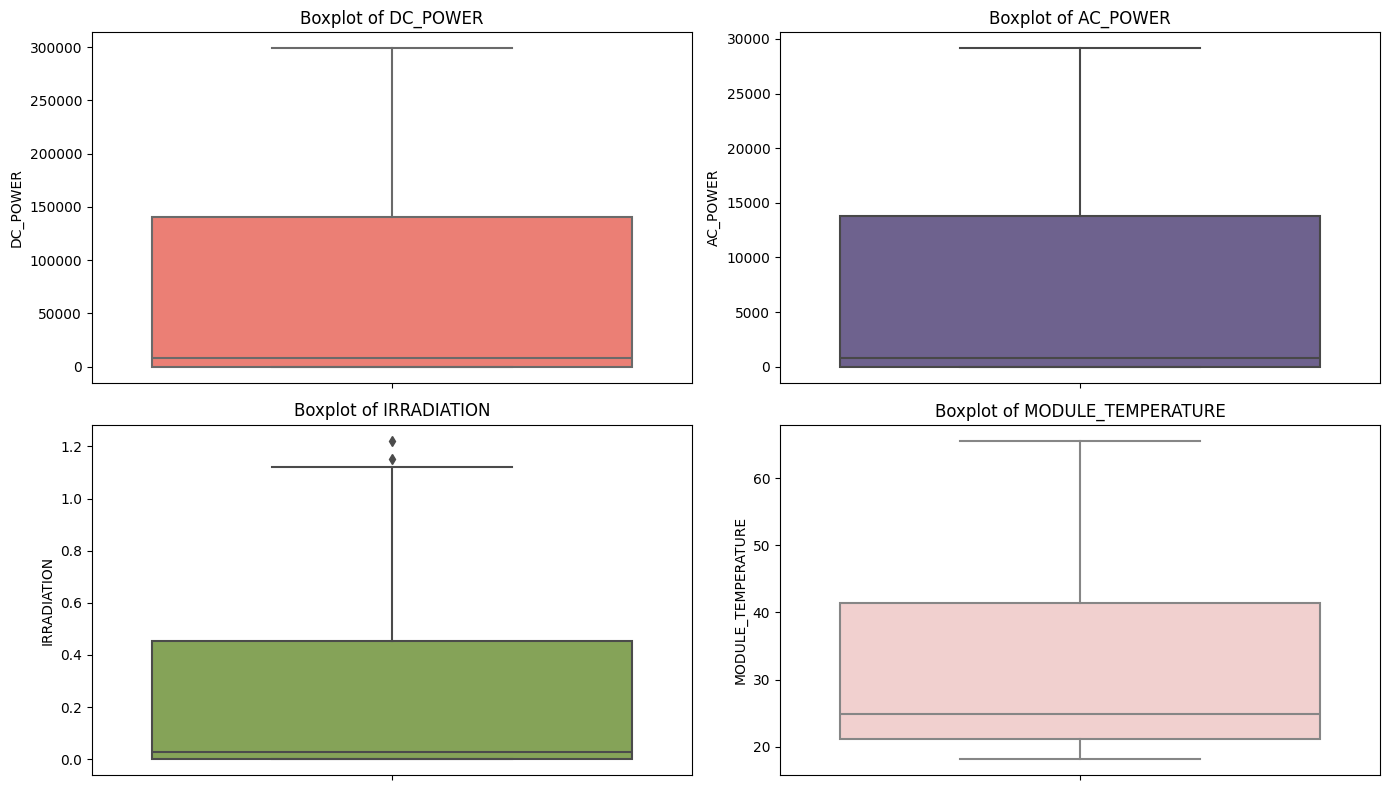

In [12]:
# Variáveis a verificar
colors = ['#FF6F61', '#6B5B95', '#88B04B', '#F7CAC9']
features = ['DC_POWER', 'AC_POWER', 'IRRADIATION', 'MODULE_TEMPERATURE']

plt.figure(figsize=(14, 8))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=power_sensor, y=feature, color=colors[i-1])
    plt.title(f'Boxplot of {feature}')
plt.tight_layout()
plt.show()

 ### Scatter Plot com o Tempo
 Útil para entender outliers ao longo da série

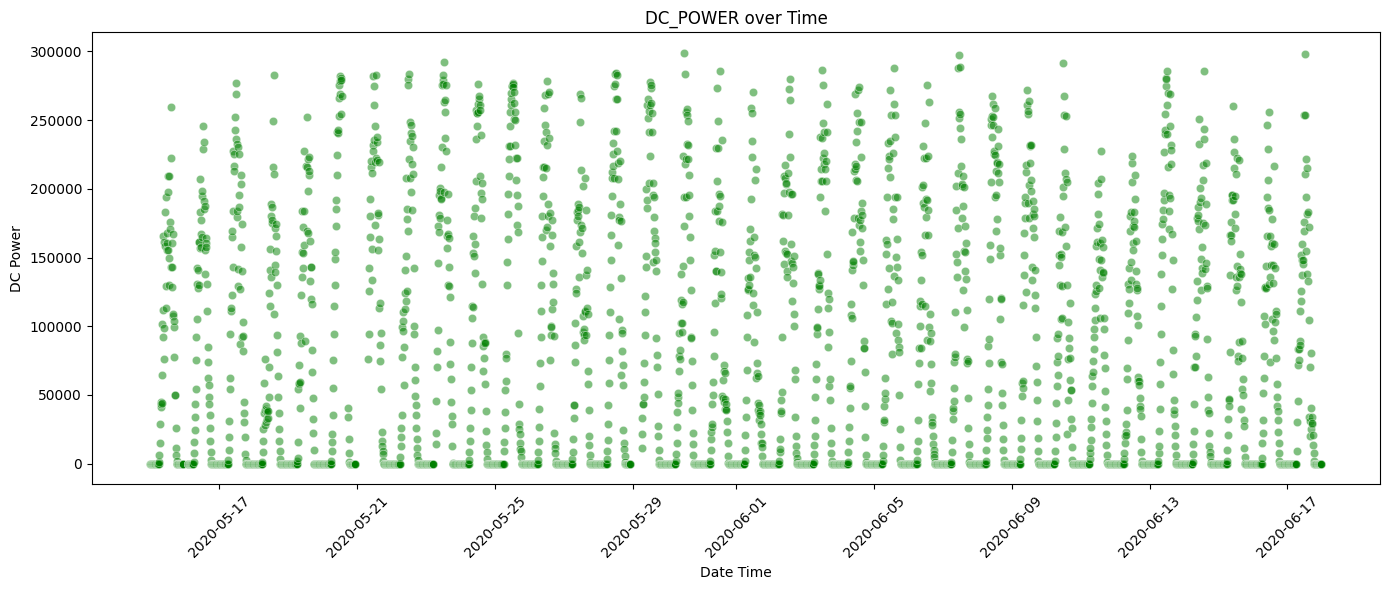

In [13]:
plt.figure(figsize=(14, 6))
sns.scatterplot(data=power_sensor, x='DATE_TIME', y='DC_POWER', color='green', alpha=0.5)
plt.title('DC_POWER over Time')
plt.xlabel('Date Time')
plt.ylabel('DC Power')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Checking for Null values

In [14]:
power_sensor.isnull().sum()

DATE_TIME              0
PLANT_ID               0
SOURCE_KEY             0
AMBIENT_TEMPERATURE    0
MODULE_TEMPERATURE     0
IRRADIATION            0
DC_POWER               0
AC_POWER               0
DAILY_YIELD            0
TOTAL_YIELD            0
dtype: int64

## Pré Processamento dos Dados

## Descriptive Statistics
Finding Mean, Median, Min and Max Values

#### Line plot com Média de DC_POWER por Dia

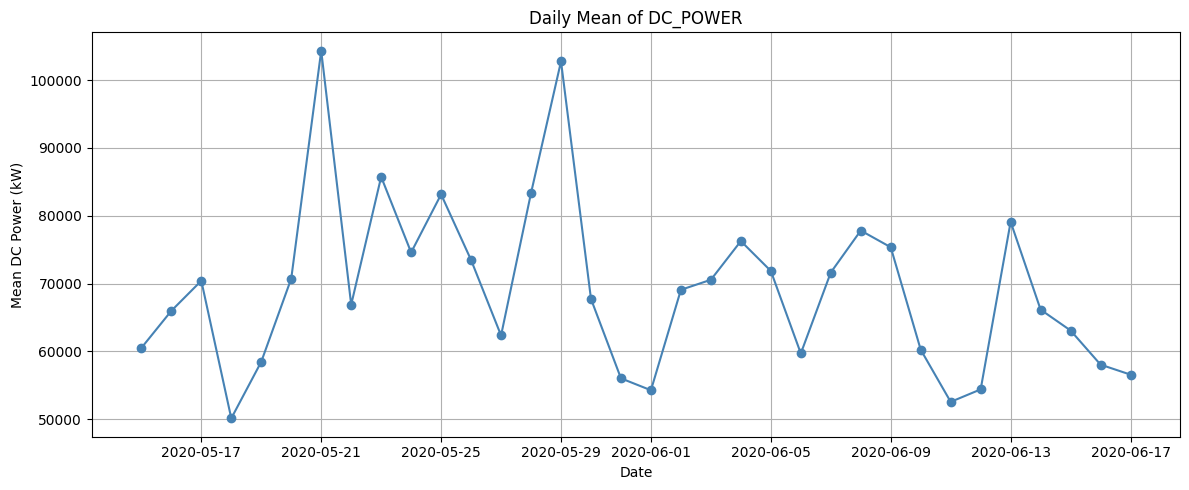

In [15]:
# Ensure datetime column is in datetime format
power_sensor['DATE_TIME'] = pd.to_datetime(power_sensor['DATE_TIME'])

# Create a new column for date only (removing time component)
power_sensor['DATE'] = power_sensor['DATE_TIME'].dt.date

# Group by DATE and calculate mean
daily_mean = power_sensor.groupby('DATE')['DC_POWER'].mean()

# Plot daily mean of DC_POWER
plt.figure(figsize=(12, 5))
daily_mean.plot(marker='o', color='steelblue')
plt.title('Daily Mean of DC_POWER')
plt.xlabel('Date')
plt.ylabel('Mean DC Power (kW)')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Line plot com Mediana de DC_POWER por Dia

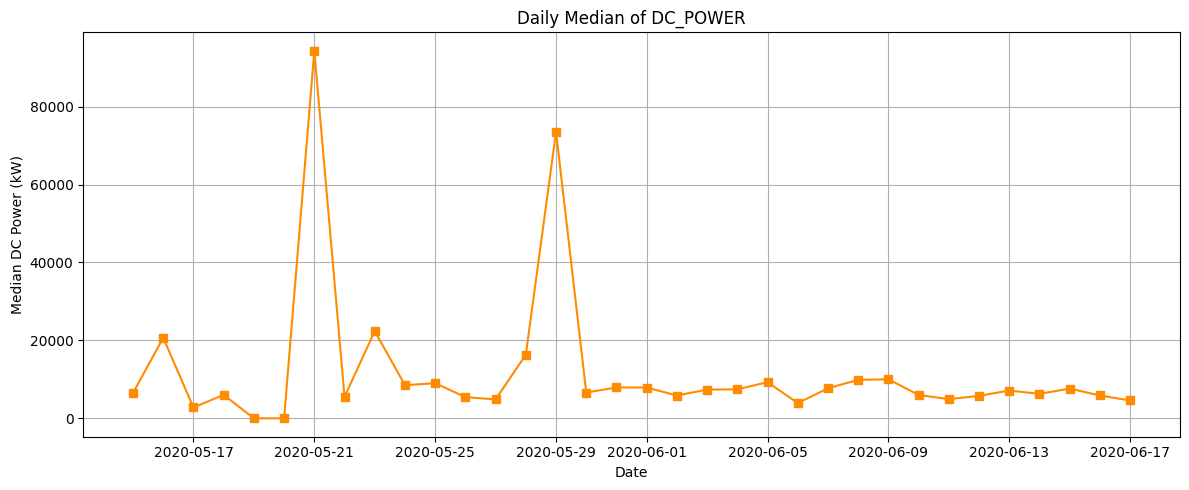

In [16]:
# Group by DATE and calculate median
daily_median = power_sensor.groupby('DATE')['DC_POWER'].median()

# Plot daily median of DC_POWER
plt.figure(figsize=(12, 5))
daily_median.plot(marker='s', color='darkorange')
plt.title('Daily Median of DC_POWER')
plt.xlabel('Date')
plt.ylabel('Median DC Power (kW)')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Function imprimir_valores_unicos()
A function that prints the unique values of each variable.

In [17]:
def imprimir_valores_unicos(data_f):
    for coluna in data_f.columns:
        valores_unicos = data_f[coluna].unique()
        print(f"  {coluna} = {valores_unicos}")

In [18]:
imprimir_valores_unicos(power_sensor)

  DATE_TIME = <DatetimeArray>
['2020-05-15 00:00:00', '2020-05-15 00:15:00', '2020-05-15 00:30:00',
 '2020-05-15 00:45:00', '2020-05-15 01:00:00', '2020-05-15 01:15:00',
 '2020-05-15 01:30:00', '2020-05-15 01:45:00', '2020-05-15 02:00:00',
 '2020-05-15 02:15:00',
 ...
 '2020-06-17 21:30:00', '2020-06-17 21:45:00', '2020-06-17 22:00:00',
 '2020-06-17 22:15:00', '2020-06-17 22:30:00', '2020-06-17 22:45:00',
 '2020-06-17 23:00:00', '2020-06-17 23:15:00', '2020-06-17 23:30:00',
 '2020-06-17 23:45:00']
Length: 3157, dtype: datetime64[ns]
  PLANT_ID = [4135001]
  SOURCE_KEY = ['HmiyD2TTLFNqkNe']
  AMBIENT_TEMPERATURE = [25.18431613 25.08458867 24.9357526  ... 22.00827464 21.96949473
 21.90928767]
  MODULE_TEMPERATURE = [22.8575074  22.76166787 22.59230553 ... 20.70921136 20.7349628
 20.4279724 ]
  IRRADIATION = [0.00000000e+00 8.62721241e-04 5.88695719e-03 ... 2.34457015e-02
 7.00688981e-03 3.90831153e-05]
  DC_POWER = [    0.           942.14880953  6142.1011903  ... 13312.0000002
  7450.62

In [19]:
power_sensor.nunique()

DATE_TIME              3157
PLANT_ID                  1
SOURCE_KEY                1
AMBIENT_TEMPERATURE    3157
MODULE_TEMPERATURE     3157
IRRADIATION            1755
DC_POWER               1688
AC_POWER               1688
DAILY_YIELD            1777
TOTAL_YIELD            1734
DATE                     34
dtype: int64

### Variable adjustment

#### Droping variables

In [20]:
power_sensor.drop(columns=['PLANT_ID'], inplace=True)
power_sensor.drop(columns=['SOURCE_KEY'], inplace=True)

### Feature Engineering for Time Series Data

In [21]:
power_sensor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3157 entries, 0 to 3156
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE_TIME            3157 non-null   datetime64[ns]
 1   AMBIENT_TEMPERATURE  3157 non-null   float64       
 2   MODULE_TEMPERATURE   3157 non-null   float64       
 3   IRRADIATION          3157 non-null   float64       
 4   DC_POWER             3157 non-null   float64       
 5   AC_POWER             3157 non-null   float64       
 6   DAILY_YIELD          3157 non-null   float64       
 7   TOTAL_YIELD          3157 non-null   float64       
 8   DATE                 3157 non-null   object        
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 222.1+ KB


#### Create time-based features
These help models capture daily and hourly patterns)

In [22]:
# Hour of the day (0 to 23)
power_sensor['hour'] = power_sensor['DATE_TIME'].dt.hour
# Day of the month
power_sensor['day'] = power_sensor['DATE_TIME'].dt.day
# Day of the week (0 = Monday, 6 = Sunday)
power_sensor['day_of_week'] = power_sensor['DATE_TIME'].dt.dayofweek

#### Create rolling mean features to smooth short-term fluctuations
This helps in capturing local trends, such as power smoothing over 1 hour (4 intervals of 15 minutes)

In [23]:
power_sensor['DC_POWER_roll_mean_1h'] = power_sensor['DC_POWER'].rolling(window=4).mean()
power_sensor['IRRADIATION_roll_mean_1h'] = power_sensor['IRRADIATION'].rolling(window=4).mean()

#### Create lag features (values from previous time steps)
These are useful to capture delayed effects, such as the impact of past irradiation on current power output

In [24]:
power_sensor['DC_POWER_lag_1'] = power_sensor['DC_POWER'].shift(1)
power_sensor['IRRADIATION_lag_1'] = power_sensor['IRRADIATION'].shift(1)

In [25]:
# Drop rows with missing values caused by rolling or lag operations
power_sensor = power_sensor.dropna()

In [26]:
power_sensor

,DATE_TIME,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,DATE,hour,day,day_of_week,DC_POWER_roll_mean_1h,IRRADIATION_roll_mean_1h,DC_POWER_lag_1,IRRADIATION_lag_1
3,2020-05-15 00:45:00,24.846130,22.360852,0.0,0.0,0.0,0.000000,143581676.0,2020-05-15,0,15,4,0.0,0.0,0.0,0.0
4,2020-05-15 01:00:00,24.621525,22.165423,0.0,0.0,0.0,0.000000,150761642.0,2020-05-15,1,15,4,0.0,0.0,0.0,0.0
5,2020-05-15 01:15:00,24.536092,21.968571,0.0,0.0,0.0,0.000000,143581676.0,2020-05-15,1,15,4,0.0,0.0,0.0,0.0
6,2020-05-15 01:30:00,24.638674,22.352926,0.0,0.0,0.0,0.000000,143581676.0,2020-05-15,1,15,4,0.0,0.0,0.0,0.0
7,2020-05-15 01:45:00,24.873022,23.160919,0.0,0.0,0.0,0.000000,150761642.0,2020-05-15,1,15,4,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3152,2020-06-17 22:45:00,22.150570,21.480377,0.0,0.0,0.0,129571.000000,156142755.0,2020-06-17,22,17,2,0.0,0.0,0.0,0.0
3153,2020-06-17 23:00:00,22.129816,21.389024,0.0,0.0,0.0,129571.000000,156142755.0,2020-06-17,23,17,2,0.0,0.0,0.0,0.0
3154,2020-06-17 23:15:00,22.008275,20.709211,0.0,0.0,0.0,129571.000000,156142755.0,2020-06-17,23,17,2,0.0,0.0,0.0,0.0
3155,2020-06-17 23:30:00,21.969495,20.734963,0.0,0.0,0.0,129571.000000,156142755.0,2020-06-17,23,17,2,0.0,0.0,0.0,0.0


In [27]:
power_sensor.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3154 entries, 3 to 3156
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   DATE_TIME                 3154 non-null   datetime64[ns]
 1   AMBIENT_TEMPERATURE       3154 non-null   float64       
 2   MODULE_TEMPERATURE        3154 non-null   float64       
 3   IRRADIATION               3154 non-null   float64       
 4   DC_POWER                  3154 non-null   float64       
 5   AC_POWER                  3154 non-null   float64       
 6   DAILY_YIELD               3154 non-null   float64       
 7   TOTAL_YIELD               3154 non-null   float64       
 8   DATE                      3154 non-null   object        
 9   hour                      3154 non-null   int32         
 10  day                       3154 non-null   int32         
 11  day_of_week               3154 non-null   int32         
 12  DC_POWER_roll_mean_1h    

#### Visualization of Rolling Mean and Lag Effects on DC_POWER

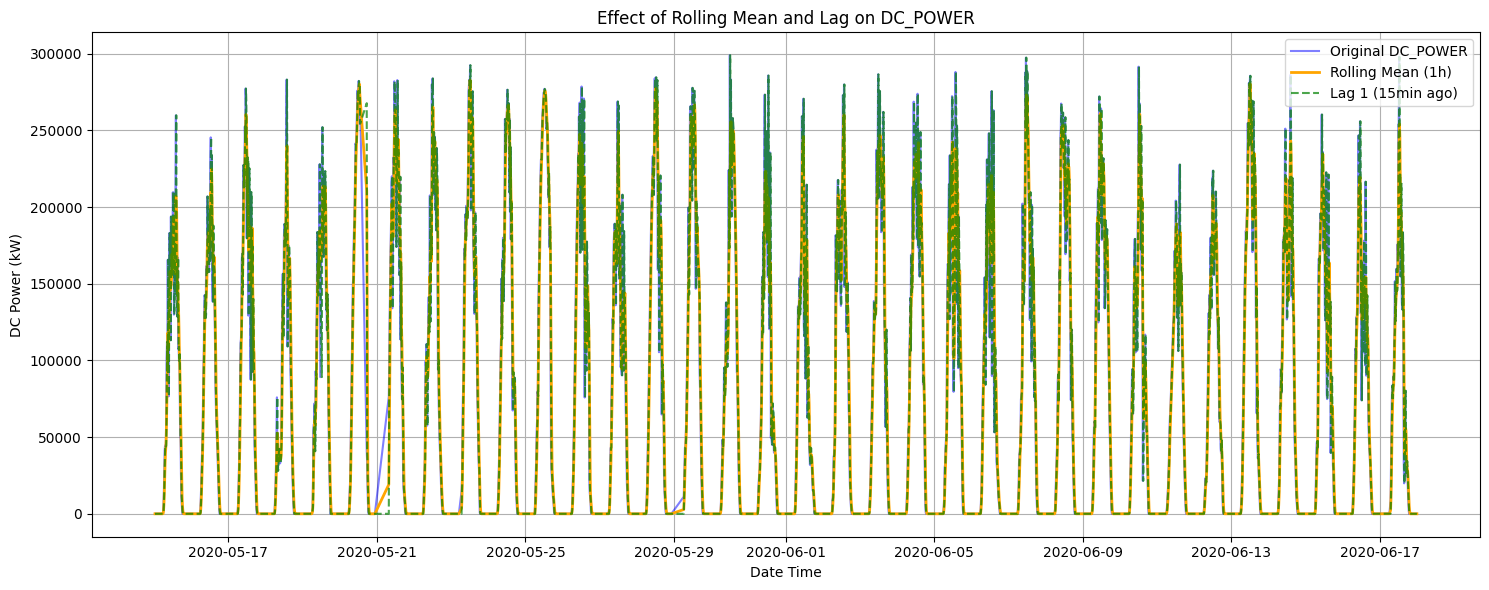

In [28]:
# Set figure size
plt.figure(figsize=(15, 6))

# Plot original DC_POWER
plt.plot(power_sensor['DATE_TIME'], power_sensor['DC_POWER'], label='Original DC_POWER', color='blue', alpha=0.5)

# Plot 1-hour rolling mean (4x 15min intervals)
plt.plot(power_sensor['DATE_TIME'], power_sensor['DC_POWER_roll_mean_1h'], label='Rolling Mean (1h)', color='orange', linewidth=2)

# Plot lagged DC_POWER (1 time step = 15 minutes before)
plt.plot(power_sensor['DATE_TIME'], power_sensor['DC_POWER_lag_1'], label='Lag 1 (15min ago)', color='green', linestyle='--', alpha=0.7)

# Titles and labels
plt.title('Effect of Rolling Mean and Lag on DC_POWER')
plt.xlabel('Date Time')
plt.ylabel('DC Power (kW)')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

### Seleção automática de features
Selecionar as features mais relevantes para prever DC_POWER, usando SelectKBest com teste estatístico (f_regression).  

In [29]:
# Separando target e features
y = power_sensor['DC_POWER']

# remove target e timestamp
X = power_sensor.drop(['DC_POWER', 'DATE_TIME'], axis=1) 

# Se houver variáveis categóricas, faça encoding (exemplo: One-Hot)
X_encoded = pd.get_dummies(X, drop_first=True)

In [30]:
# Aplicando SelectKBest
from sklearn.feature_selection import SelectKBest, f_regression

selector = SelectKBest(score_func=f_regression, k='all')
X_new = selector.fit_transform(X_encoded, y)

# Mostrando os scores das features
import pandas as pd

feature_scores = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Score': selector.scores_
}).sort_values(by='Score', ascending=False)

display(feature_scores)

,Feature,Score
3,AC_POWER,5.615542e+08
2,IRRADIATION,3.872594e+05
9,DC_POWER_roll_mean_1h,5.210021e+04
10,IRRADIATION_roll_mean_1h,4.695878e+04
1,MODULE_TEMPERATURE,3.798266e+04
11,DC_POWER_lag_1,3.612090e+04
12,IRRADIATION_lag_1,3.015942e+04
0,AMBIENT_TEMPERATURE,3.508567e+03
5,TOTAL_YIELD,3.565591e+01
4,DAILY_YIELD,2.674251e+01


# Exploratory Data Analysis

Data Understanding, Cleaning, Preprocessing, and Various Analyses

### Heatmap
Displaying the correlation between power and temperature variables.

In [31]:
c= power_sensor.corr()
c

TypeError: float() argument must be a string or a number, not 'datetime.date'

In [ ]:
# Calculate the Spearman correlation matrix for the columns of power_sensor, excluding 'DAILY_YIELD' and 'TOTAL_YIELD'
corr = power_sensor.drop(columns=['DAILY_YIELD', 'TOTAL_YIELD']).corr(method='spearman')

# Create a new figure with a specified DPI
plt.figure(dpi=100)

# Create a heatmap plot of the correlation matrix using seaborn and display the plot
sns.heatmap(corr, robust=True, annot=True, linewidths=.5, square=True)
plt.show()

## Matrix of Scatter Plots

Exploring relationships and correlations between variables in the power and sensor dataset, to quickly understand how variables interact with each other.

In [ ]:
sns.pairplot(power_sensor.drop(columns=['DAILY_YIELD', 'TOTAL_YIELD']))
plt.show()

## Scatter Plot and Mean DC Power

Plot the data points from the 'DC_POWER' column against the 'time' column in the format of a scatter plot and plot the mean of DC power on a line graph.

In [ ]:
# Plot the 'DC_POWER' column vs the 'time' column of plant1_data
plant1_data.plot(x='time', y='DC_POWER', style='.', figsize=(15, 8))

# Group the data by 'time' and calculate the mean of 'DC_POWER' for each time
plant1_data.groupby('time')['DC_POWER'].agg('mean').plot(legend=True, colormap='Reds_r')

# Adding labels and title
plt.ylabel('DC Power')
plt.title('DC POWER plot')

# Display the plot
plt.show()

## Daily Yield
### Histogram

In [ ]:
# Plotting the histogram
plt.hist(plant1_data['DAILY_YIELD'], bins=10, color='skyblue', edgecolor='black')

# Adding labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('DAILY_YIELD Histogram')

### Scatter Plot and Yield Mean

Plot the data points from the 'DAILY_YIELD' column against the 'time' column in the format of a scatter plot and plot the mean of daily yield on a line graph.

In [ ]:
# Plot the 'DAILY_YIELD' column against the 'time' column of plant1_data
plant1_data.plot(x='time', y='DAILY_YIELD', style='r.', figsize=(15, 5))

# Group the data by 'time' and calculate the mean of 'DAILY_YIELD' for each time
plant1_data.groupby('time')['DAILY_YIELD'].agg('mean').plot(legend=True, colormap='Reds_r')

# Set the title, labels and display the plot
plt.title('DAILY YIELD')
plt.ylabel('Yield')
plt.show()

### Daily Yield and AC-DC Power
Transform the original data into a new DataFrame (df_daily_gen), grouping the values for each time interval and adding an additional column ('time') to allow time-based analysis.

In [ ]:
# Group the DataFrame data by the 'DATE_TIME' column and reset the DataFrame index
df_daily_gen = df_gen.groupby('DATE_TIME').sum().reset_index()

# Create a new column 'time' in the DataFrame
df_daily_gen['time'] = df_daily_gen['DATE_TIME'].dt.time

# Remove the 'DATE_TIME' column from the DataFrame and set 'time' as the new index
df_daily_gen.set_index('time', inplace=True)
df_daily_gen.drop(columns=['DATE_TIME'], inplace=True)

# Plot AC_POWER and DC_POWER
ax = df_daily_gen[['AC_POWER', 'DC_POWER']].plot(style='o', color=["r", 'skyblue'])
ax.set_title('AC power & DC power during day hours')
ax.set_ylabel('kW', color='navy', fontsize=17)

## Module Temperature
### Histogram

In [ ]:
# Plotting the histogram
plt.hist(plant1_sensor['MODULE_TEMPERATURE'], bins=10, color='skyblue', edgecolor='black')

# Adding labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('MODULE_TEMPERATURE Histogram')

In [ ]:
# Plot the 'MODULE_TEMPERATURE' column against the 'time' column of plant1_sensor
plant1_sensor.plot(x='time', y='MODULE_TEMPERATURE', figsize=(15, 8), style='.')

# Group the data by 'time' and calculate the mean of 'MODULE_TEMPERATURE' for each time,
# then plot the mean values as a line plot
plant1_sensor.groupby('time')['MODULE_TEMPERATURE'].agg('mean').plot(colormap='Reds_r', legend=True)

# Set the title and the labels
plt.title('DAILY MODULE TEMPERATURE & MEAN(red)')
plt.ylabel('Temperature(°C)')

### Data Information
power_sensor is the DataFrame containing the merged data of power generation and temperature from the Solar Plant. These data will be used in the machine learning model.

In [ ]:
power_sensor

In [ ]:
power_sensor.info()

### Training and Test Sets
Selecting three columns from the power_sensor DataFrame to be our input features (features) and selecting the 'DC_POWER' column from the power_sensor DataFrame to be our prediction target.

In [ ]:
# Splitting the data into features (X) and target (y)
X = power_sensor[['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']]
y = power_sensor['DC_POWER']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Linear Regression Model
Using temperature and irradiation data, a linear regression model was used to predict energy generation.

Initializing a linear regression model object.
Training the linear regression model using the training datasets.
Using the trained model to make predictions on the test data.

In [ ]:
# Initializing and training the linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Making predictions on the test set
lr_prev = lr_model.predict(X_test)

#### Coefficient of Determination \( R^2 \)
Calculates the coefficient of determination \( R^2 \) (R-squared) to evaluate the performance of the linear regression model.
It takes as input the actual values from the test set and the predictions made by the model. The closer to 1, the better the model is at explaining the variability of the data.inear.

In [ ]:
# Calculating the R² score
r2 = r2_score(y_test, lr_prev)
print("Coefficient of Determination (R²):", r2)

#### MSE and MAE
- MSE is a measure of the average squared error between predictions and actual values. The lower the MSE, the better the model is at fitting the data.
- MAE is a measure of the average absolute differences between predictions and actual values. The lower the MAE, the better the model's performance.

In [ ]:
# Evaluating the model performance
mse = mean_squared_error(y_test, lr_prev)
mae = mean_absolute_error(y_test, lr_prev)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

#### Actual Values vs. Predictions

In [ ]:
# Plotting actual values against predictions
plt.figure(figsize=(8, 6))
plt.scatter(x=y_test, y=lr_prev, color='green', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', lw=1)
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.title('Actual Values vs. Predictions')
plt.grid(True)
plt.show()

### Random Forest

In [ ]:
#Create a Gaussian Classifier
clf_RF = RandomForestRegressor(n_estimators = 1000)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf_RF.fit(X_train, y_train)

rf_prev = clf_RF.predict(X_test)

#### Coefficient of Determination \( R^2 \)

In [ ]:
# Calculating the R² score
r2 = r2_score(y_test, rf_prev)
print("Coefficient of Determination (R²):", r2)

#### MSE and MAE

In [ ]:
# Evaluating the model performance
mse = mean_squared_error(y_test, rf_prev)
mae = mean_absolute_error(y_test, rf_prev)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

In [ ]:
#### Actual Values vs. Predictions

In [ ]:
# Plotting actual values against predictions
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=rf_prev, color='green', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', lw=1)
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.title('Actual Values vs. Predictions')
plt.grid(True)
plt.show()